# Experimento 5:  MC com inícios exploratórios

## Importações

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from typing import Dict, Tuple, List, Union
from collections import defaultdict
from tqdm.auto import tqdm

/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Ambiente: Navegação no Labirinto (gridworld)

In [3]:
class AmbienteNavegacaoLabirinto:
    def __init__(self, world_size, bad_states, target_states, allow_bad_entry=False, rewards=[-1, -1, 1, 0]):
        """
        Inicializa o ambiente de navegação em labirinto.

        Parâmetros:
        - world_size: tupla (n_linhas, n_colunas)
        - bad_states: lista de tuplas com coordenadas de estados penalizados
        - target_states: lista de tuplas com coordenadas dos estados de objetivo
        - allow_bad_entry: bool, se False impede entrada em estados ruins (rebote)
        - rewards: lista de recompensas com [r_boundary, r_bad, r_target, r_other]
        """
        self.n_rows, self.n_cols = world_size   # dimensões da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Recompensas definidas para cada tipo de transição
        self.r_boundary = rewards[0]  # tentar sair da grade
        self.r_bad = rewards[1]       # transição para estado ruim
        self.r_target = rewards[2]    # transição para estado alvo
        self.r_other = rewards[3]     # demais transições

        # Espaço de ações: dicionário com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espaço de recompensas: lista de recompensas possíveis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # número total de estados
        self.n_states = self.n_rows * self.n_cols

        # número total de ações
        self.n_actions = len(self.action_space)

        # número total de recompensas possíveis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transição: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata (determinística): recompensa[s, a] = r
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        # Matriz de transição de estados (determinística): transicao[s, a] = s'
        self.transicao_de_estados = np.zeros((self.n_states, self.n_actions), dtype=int)

        self.agent_pos = (0, 0)  # posição inicial do agente

        self._init_dynamics()  # inicializa as dinâmicas de transição e recompensa


    def _init_dynamics(self):
        """
        Preenche as matrizes de transição e recompensa com base
        na estrutura do ambiente e regras de movimentação.
        """
        for indice_estado in range(self.n_states):
            estado_atual = self.index_to_state(indice_estado)

            for acao, (d_linha, d_coluna) in self.action_space.items():
                proxima_posicao = (estado_atual[0] + d_linha, estado_atual[1] + d_coluna)

                # Verifica se o movimento é válido ou resulta em rebote
                if not self._in_bounds(proxima_posicao) or (not self.allow_bad_entry and proxima_posicao in self.bad_states):
                    proximo_estado = estado_atual  # rebote: permanece no estado atual
                else:
                    proximo_estado = proxima_posicao

                # Calcula a recompensa imediata da transição (s, a)
                recompensa = self._compute_reward(proxima_posicao)

                # Armazena a recompensa imediata na matriz
                self.recompensas_imediatas[indice_estado, acao] = recompensa

                # Ambiente determinístico
                indice_proximo = self.state_to_index(proximo_estado)
                self.state_transition_probabilities[indice_proximo, indice_estado, acao] = 1.0  # registra probabilidade P(s'|s,a)
                indice_recompensa = self.reward_map[recompensa]
                self.reward_probabilities[indice_recompensa, indice_estado, acao] = 1.0  # registra probabilidade P(r|s,a)

                # Armazena transição determinística (s, a) -> s'
                self.transicao_de_estados[indice_estado, acao] = indice_proximo


    def reset(self):
        """Reinicia a posição do agente para o estado inicial (0, 0)."""
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao: int, *, linear: bool = False) -> Tuple[Union[int, Tuple[int, int]], float]:
        """
        Executa uma ação no ambiente, atualiza a posição do agente e devolve o próximo estado no formato desejado.

        Parâmetros
        ----------
        acao   : int
            Índice da ação a ser executada (0‒4).
        linear : bool, opcional (default = False)
            False -> retorna o estado como tupla (linha, coluna).
            True  -> retorna o estado como índice linear {0,...,self.n_states-1}.

        Retorna
        -------
        proximo_estado : (linha, coluna) | int
            Nova posição do agente (próximo estado) no formato especificado.
        recompensa     : float
            Recompensa imediata recebida.
        """
        d_linha, d_coluna = self.action_space[acao]
        linha_dest = self.agent_pos[0] + d_linha
        coluna_dest = self.agent_pos[1] + d_coluna
        destino = (linha_dest, coluna_dest)

        # Rebote se fora dos limites ou entrada em bad_state proibida
        if not self._in_bounds(destino) or (not self.allow_bad_entry and destino in self.bad_states):
            destino = self.agent_pos  # permanece

        recompensa = self._compute_reward(destino)
        self.agent_pos = destino

        # --- Formato de retorno ---
        proximo_estado = self.state_to_index(destino) if linear else destino

        return proximo_estado, recompensa


    def _in_bounds(self, posicao):
        """Verifica se uma posição está dentro dos limites do labirinto."""
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino):
        """
        Define a recompensa com base no destino proposto:
        - r_boundary: fora do grid
        - r_bad: célula ruim
        - r_target: célula alvo
        - r_other: demais casos
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif destino in self.bad_states:
            return self.r_bad
        elif destino in self.target_states:
            return self.r_target
        else:
            return self.r_other


    def reset_to_state(self, state, verify_bounds: bool = True):
        """
        Teleporta o agente para 'state' sem reiniciar o episódio completo.

        Parâmetros
        ----------
        state : (int, int) | int
            - Tupla (linha, coluna)
            ou
            - Índice linear (int)
        verify_bounds : bool
            Se True, lança ValueError se o estado não for válido.

        Retorna
        -------
        observation : object
            A observação correspondente ao novo estado (a própria posição).
        """
        # Converte índice -> tupla, se necessário
        if isinstance(state, int):
            state = self.index_to_state(state)

        if verify_bounds and not self._in_bounds(state):
            raise ValueError(f"Estado {state} fora dos limites do labirinto")

        self.agent_pos = tuple(state)      # mantém tupla imutável

        return self.agent_pos


    def state_to_index(self, estado):
        """Converte coordenada (linha, coluna) para índice linear."""
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice):
        """Converte índice linear para coordenada (linha, coluna)."""
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)

## Funções auxiliares para visualização

In [4]:
def plot_policy(env, policy, ax=None, titulo="Política"):
    _, ax = _prepare_grid(env, ax=ax)

    for (r, c), action in policy.items():
        x, y = c + 0.5, r + 0.5
        color = 'black'
        lw = 1.5

        if action == 0:
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title(titulo)
    if ax is None:
        plt.show()


def _prepare_grid(env, ax=None, draw_cells=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))
    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle(xy=(c, r), width=1, height=1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return (None, ax) if ax else (fig, ax)

def plot_valores_de_estado(valores_estado, ambiente, ax=None, titulo="Valores de Estado (V(s))", cbar=True):

    dados = valores_estado.reshape(ambiente.n_rows, ambiente.n_cols)

    if ax is None:
        fig, ax = plt.subplots(figsize=(ambiente.n_cols, ambiente.n_rows))

    sns.heatmap(
        data=dados,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        square=True,
        cbar=cbar,
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    ax.set_title(titulo)
    if ax is None:
        plt.tight_layout()
        plt.show()



def plot_valores_de_acao(valores_de_acao):
    Q_transposta = valores_de_acao.T
    n_acoes, n_estados = Q_transposta.shape

    plt.figure(figsize=(n_estados, n_acoes))
    ax = sns.heatmap(
        Q_transposta,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        cbar=True,
        square=False,
        linewidths=0.5,
        linecolor='gray'
    )
    # Rótulos das colunas (estados)
    ax.set_xticks(np.arange(n_estados) + 0.5)
    ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)

    # Rótulos das linhas (ações)
    ax.set_yticks(np.arange(n_acoes) + 0.5)
    ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    ax.set_xlabel(r"Estados")
    ax.set_ylabel(r"Ações")
    ax.set_title(r"Valores de ação (Q(s, a) transposta)")
    plt.tight_layout()
    plt.show()


def plot_labirinto(ambiente):
    """
    Visualiza o labirinto usando seaborn.heatmap sem ticks nos eixos.

    Representa:
    - Estado neutro: branco
    - Estado ruim: vermelho
    - Estado alvo: verde
    """
    # Cria matriz com valores padrão (0 = neutro)
    matriz = np.zeros((ambiente.n_rows, ambiente.n_cols), dtype=int)

    # Marca os estados ruins como 1
    for (r, c) in ambiente.bad_states:
        matriz[r, c] = 1

    # Marca os estados alvo como 2
    for (r, c) in ambiente.target_states:
        matriz[r, c] = 2

    # Mapa de cores: branco = neutro, vermelho = ruim, verde = alvo
    cmap = ListedColormap(["white", "red", "green"])

    plt.figure(figsize=(ambiente.n_cols, ambiente.n_rows))
    ax = sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True
    )

    # Remove todos os ticks e labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title("Visualização do Labirinto")
    plt.tight_layout()
    plt.show()


def plot_visitas_log(n_visitas):
    """
    Gera um gráfico de dispersão com escala logarítmica no eixo y
    mostrando o número de visitas para cada par (s,a).

    Parâmetros
    ----------
    n_visitas : np.ndarray
        Matriz de número de visitas de shape (n_states, n_actions).
    """
    n_states, n_actions = n_visitas.shape
    x = np.arange(n_states * n_actions)  # índice linear do par (s,a)
    y = n_visitas.flatten()              # número de visitas

    plt.figure(figsize=(8, 4))
    plt.scatter(x, y, s=10, alpha=0.7)
    plt.yscale('log')
    plt.xlabel("Índice linear do par (s,a)")
    plt.ylabel("Número de visitas ao par (s,a)")
    plt.title("Frequência de visitas (escala log)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## MC com inícios exploratórios

In [5]:
def gerar_episodio_es(
    ambiente,
    estado_inicial: int,
    acao_inicial: int,
    politica: Dict[int, int],
    T: int,
) -> List[Tuple[int, int, float]]:
    """
    Gera um episódio de comprimento fixo T atendendo à condição
    de inicios exploratórios — isto é, começando pelo par (estado_inicial, acao_inicial)
    que é imposto — e em seguida seguindo a política atual.
    Cada passo armazenado na trajetória contém a tupla (s_t, a_t, r_{t+1}).

    ----------
    Parâmetros
    ----------
    ambiente : AmbienteNavegacaoLabirinto
        Instância do gridworld.
    estado_inicial : int
        Índice linear do estado em que o episódio começa (s_0).
    acao_inicial : int
        Ação forçada no primeiro passo (a_0) para garantir cobertura de todos os pares (s,a).
    politica : Dict[int, int]
        Política determinística seguida do segundo passo em diante.
    T : int
        Horizonte fixo — número de passos do episódio (>= 1).

    ----------
    Retorno
    -------
    trajetoria
    """

    ambiente.reset_to_state(estado_inicial)
    
    # Inicializa a trajetória a partir do estado_atual
    trajetoria = []
    
    estado_atual = estado_inicial
    
    for t in range(T):
        if t == 0:
            # Primeiro passo: usa a ação inicial imposta (início exploratório)
            acao = acao_inicial
        else:
            # Passos subsequentes: segue a política
            acao = politica[estado_atual]
        
        # Executa a ação e obtém o próximo estado e recompensa
        proximo_estado, recompensa = ambiente.step(acao)
        
        # Armazena a tupla (s_t, a_t, r_{t+1})
        trajetoria.append((estado_atual, acao, recompensa))
        
        # Atualiza o estado atual
        estado_atual = ambiente.state_to_index(proximo_estado)
    
    return trajetoria


def mc_inicios_exploratorios(
    ambiente,
    gamma: float = 0.9,
    n_episodios: int = 10_000,
    horizonte_T: int = 50,
) -> Tuple[np.ndarray,
           Dict[Tuple[int,int],int],
           np.ndarray]:
    """
    Implementa o MC com Inícios Exploratórios para o AmbienteNavegacaoLabirinto.

    Para cada episódio:
      1. Sorteia uniformemente um par inicial (s_0, a_0) — condição de inícios exploratórios;
      2. Gera um episódio de comprimento fixo (horizonte_T) seguindo a política corrente;
      3. Percorre a trajetória de trás para frente, acumulando o retorno G e atualizando a estimativa de Q(s,a);
      4. Imediatamente após cada atualização de Q(s_t, . ), executa a etapa de melhoria de política (determinística e gulosa).

    A política é mantida internamente como dicionário {índice linear: ação} e convertida para {(linha, coluna): ação} apenas no retorno da função.

    ----------
    Parâmetros
    ----------
    ambiente    : AmbienteNavegacaoLabirinto
        Gridworld determinístico onde o agente navega.
    gamma       : float, opcional (default=0.9)
        Fator de desconto
    n_episodios : int, opcional (default=10 000)
        Número total de episódios a serem executados.
    horizonte_T : int, opcional (default=50)
        Comprimento fixo de cada episódio.

    ----------
    Retorno
    ----------
    Q                 : np.ndarray, shape = (n_states, n_actions)
        Estimativas finais de Q(s,a) obtidas por média de retornos.
    politica          : Dict[(int,int), int]
        Política determinística ótima no formato {(linha, coluna): ação}.
    numero_de_visitas : np.ndarray, shape = (n_states, n_actions)
        Matriz com o número de visitas a cada par (s,a) durante todo o processo.
    """

    n_estados, n_acoes = ambiente.n_states, ambiente.n_actions

    # ---------- Inicializações ----------
    Q                     = np.zeros((n_estados, n_acoes))
    soma_dos_retornos     = np.zeros((n_estados, n_acoes))
    numero_de_visitas     = np.zeros((n_estados, n_acoes))

    politica: Dict[int, int] = {s: np.random.randint(n_acoes) for s in range(n_estados)}

    # Loop principal: executa n_episodios episódios
    for episodio in tqdm(range(n_episodios), desc="Executando MC com Inícios Exploratórios"):
        
        # 1. Sorteio uniforme do par inicial (s_0, a_0) - condição de inícios exploratórios
        estado_inicial = np.random.randint(n_estados)
        acao_inicial = np.random.randint(n_acoes)
        
        # 2. Gera episódio de comprimento fixo seguindo a política corrente
        trajetoria = gerar_episodio_es(
            ambiente=ambiente,
            estado_inicial=estado_inicial,
            acao_inicial=acao_inicial,
            politica=politica,
            T=horizonte_T
        )
        
        # 3. Processamento da trajetória de trás para frente - every-visit MC
        G = 0.0  # Retorno acumulado
        
        # Percorre a trajetória de trás para frente
        for t in reversed(range(len(trajetoria))):
            estado, acao, recompensa = trajetoria[t]
            
            # Atualização do retorno (G =  gamma * G + r_{t+1})
            G = gamma * G + recompensa

            # Atualização da estimativa de Q(s,a) usando média incremental
            numero_de_visitas[estado, acao] += 1
            soma_dos_retornos[estado, acao] += G
            Q[estado, acao] = soma_dos_retornos[estado, acao] / numero_de_visitas[estado, acao]
            
            # 4. Melhoria de política: política gulosa em relação a Q
            # Para o estado atual, escolhe a ação que maximiza Q(s,a)
            politica[estado] = np.argmax(Q[estado, :])
    
    # Converte a política de {índice: ação} para {(linha, coluna): ação}
    politica_coord = {}
    for estado_idx in range(n_estados):
        linha, coluna = ambiente.index_to_state(estado_idx)
        politica_coord[(linha, coluna)] = politica[estado_idx]

    return Q, politica_coord, numero_de_visitas


## Ambiente

In [6]:
# Instancia o ambiente
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,           # permite entrar em estados ruins
        rewards=[-1, -10, 1, 0]
    )

## Experimento

In [7]:
Q_es, politica_es, n_visitas = mc_inicios_exploratorios(
    ambiente,             # gridworld
    gamma=0.9,            # fator de desconto
    n_episodios=10_000,   # número total de episódios
    horizonte_T=100       # comprimento fixo de cada episódio
)

Executando MC com Inícios Exploratórios: 100%|██████████| 10000/10000 [00:01<00:00, 6489.48it/s]


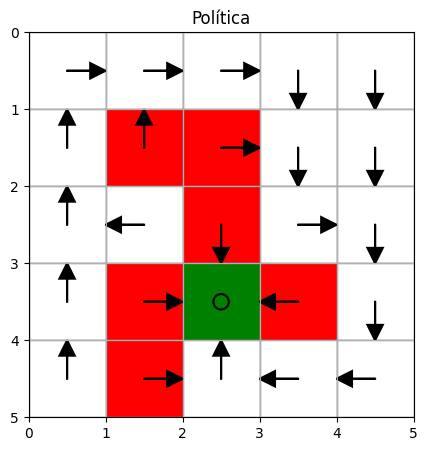

In [8]:
# Visualização
plot_policy(ambiente, politica_es, titulo="Política")

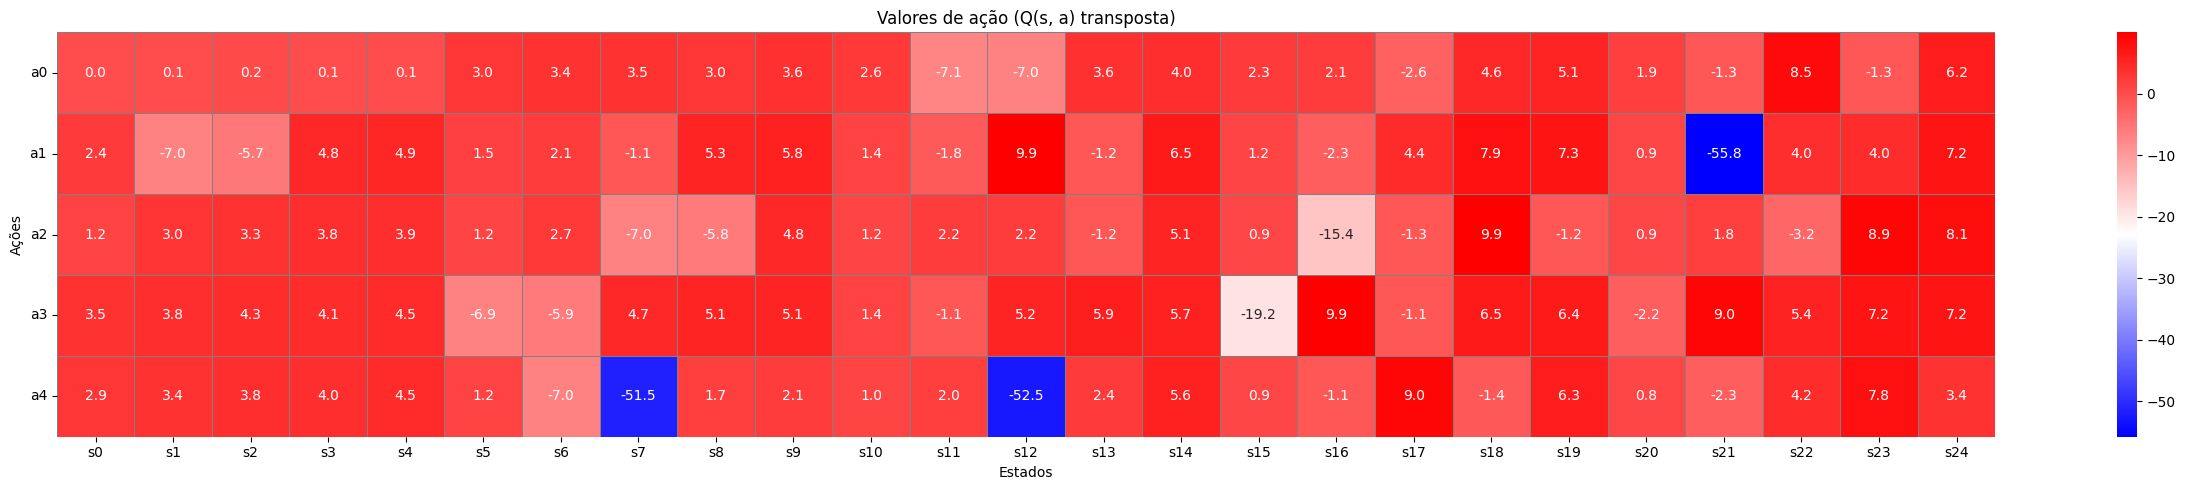

In [9]:
plot_valores_de_acao(Q_es)

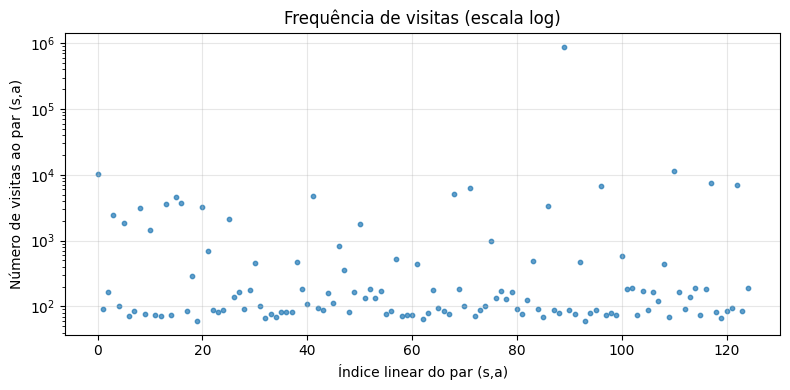

In [10]:
plot_visitas_log(n_visitas)

# Tarefa
1. Implementar o método MC com inícios aleatórios.

2. Analise o impacto o comprimento do episódio (T). Fixe n_episodios e o fator de desconto e varie T.

3. Analise o impacto do número de episódios: Fixe T e o fator de desconto e varie n_episodios.

4. Analise o impacto do número do fator de desconto: Fixe T e episodios e varie o fator de desconto.

Após cada experimento, plote:

    - número de visitas por (s,a)
    
    - política aprendida

A tarefa deve ser entregue com:
- código bem comentado (.ipynb),
- gráficos comparativos,
- breve relatório discutindo as observações.

In [11]:
# Teste simples da função step do ambiente
print("Testando o ambiente...")
ambiente.reset()
print(f"Posição inicial: {ambiente.agent_pos}")

# Teste algumas ações
for i in range(3):
    next_state, reward = ambiente.step(1)  # ação 1 = baixo
    print(f"Após ação 1 (baixo): Estado {next_state}, Recompensa {reward}")

print(f"\nNúmero total de visitas no MC: {np.sum(n_visitas)}")
print(f"Max Q-value: {np.max(Q_es)}")
print(f"Min Q-value: {np.min(Q_es)}")
print(f"Alguma visita > 0: {np.any(n_visitas > 0)}")

# Teste básico de um episódio
print("\n--- Teste de episódio ---")
politica_teste = {s: 3 for s in range(ambiente.n_states)}
episodio = gerar_episodio_es(ambiente, 0, 1, politica_teste, 3)
print(f"Episódio: {episodio}")

Testando o ambiente...
Posição inicial: (0, 0)
Após ação 1 (baixo): Estado (1, 0), Recompensa 0
Após ação 1 (baixo): Estado (2, 0), Recompensa 0
Após ação 1 (baixo): Estado (3, 0), Recompensa 0

Número total de visitas no MC: 1000000.0
Max Q-value: 9.948996253858217
Min Q-value: -55.77953066747693
Alguma visita > 0: True

--- Teste de episódio ---
Episódio: [(0, 1, 0), (5, 3, -10), (6, 3, -10)]


1. ANÁLISE DO IMPACTO DO COMPRIMENTO DO EPISÓDIO (T)

Testando T = 10...


Executando MC com Inícios Exploratórios:   0%|          | 0/5000 [00:00<?, ?it/s]

Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 53681.59it/s]




Testando T = 50...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 12458.77it/s]



Testando T = 100...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 6352.87it/s]



Testando T = 200...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:01<00:00, 3248.99it/s]



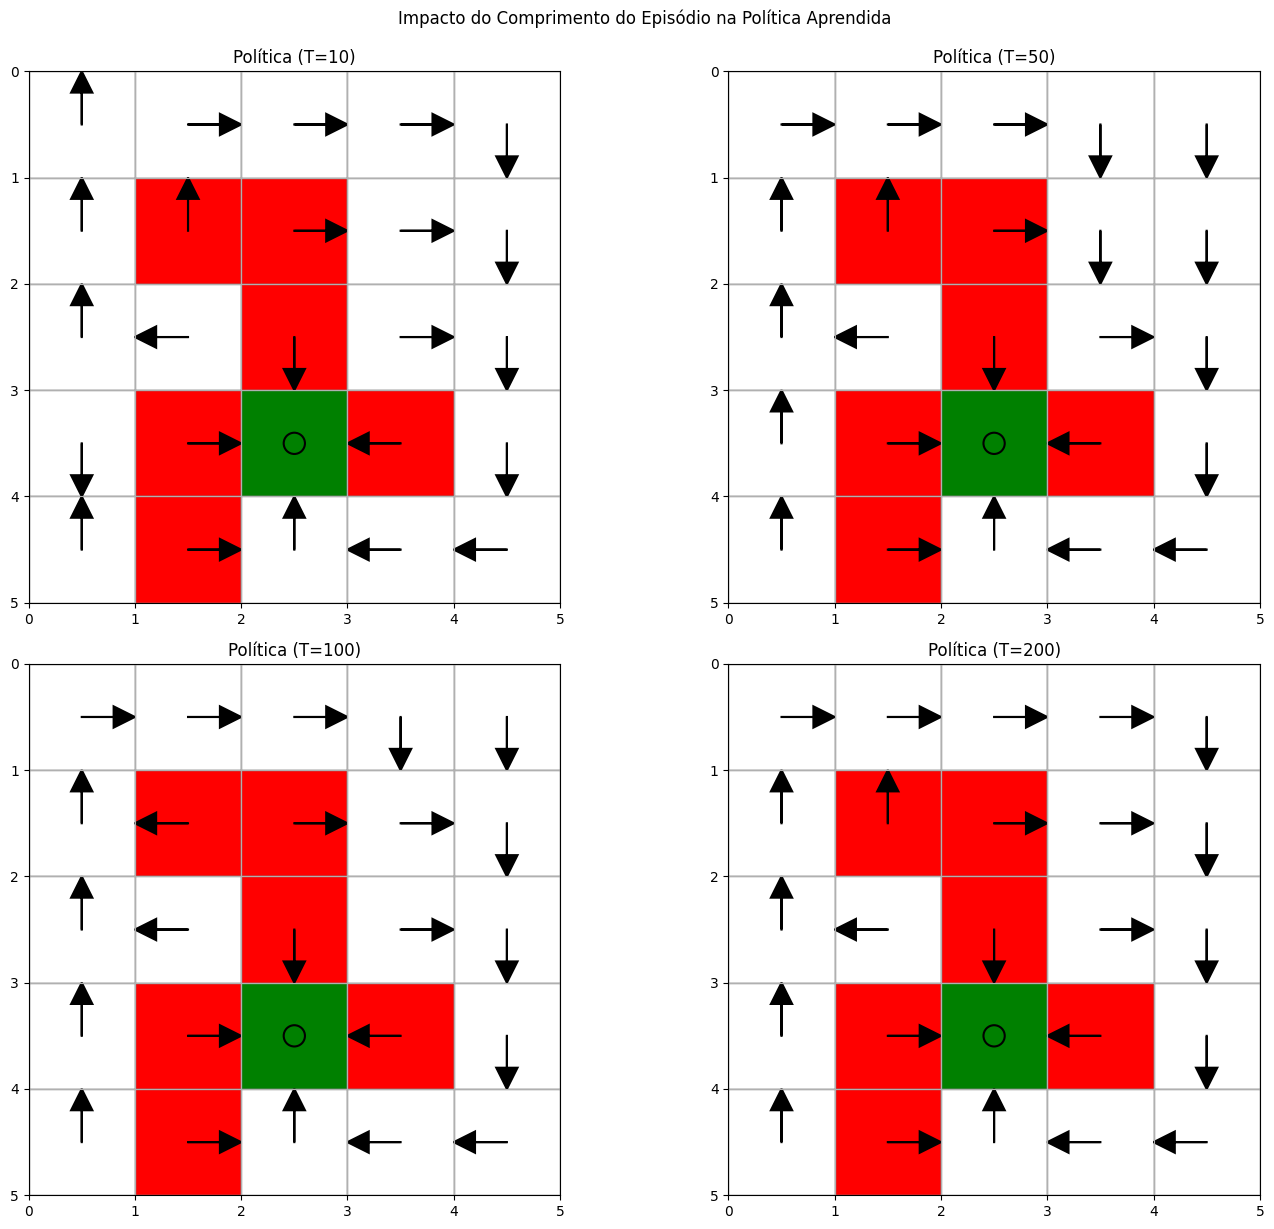

In [12]:
# Análise do impacto dos parâmetros conforme solicitado na tarefa

# 1. Impacto do comprimento do episódio (T)
print("=" * 60)
print("1. ANÁLISE DO IMPACTO DO COMPRIMENTO DO EPISÓDIO (T)")
print("=" * 60)

T_values = [10, 50, 100, 200]
gamma_fixo = 0.9
n_ep_fixo = 5000

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

resultados_T = {}

for i, T in enumerate(T_values):
    print(f"\nTestando T = {T}...")
    Q_T, pol_T, vis_T = mc_inicios_exploratorios(
        ambiente, 
        gamma=gamma_fixo, 
        n_episodios=n_ep_fixo, 
        horizonte_T=T
    )
    
    resultados_T[T] = (Q_T, pol_T, vis_T)
    
    # Plota a política
    plot_policy(ambiente, pol_T, ax=axes[i], titulo=f"Política (T={T})")
    
plt.tight_layout()
plt.suptitle("Impacto do Comprimento do Episódio na Política Aprendida", y=1.02)
plt.show()


2. ANÁLISE DO IMPACTO DO NÚMERO DE EPISÓDIOS

Testando n_episodios = 1000...


Executando MC com Inícios Exploratórios: 100%|██████████| 1000/1000 [00:00<00:00, 6494.50it/s]



Testando n_episodios = 5000...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 6441.71it/s]



Testando n_episodios = 10000...


Executando MC com Inícios Exploratórios: 100%|██████████| 10000/10000 [00:01<00:00, 6634.03it/s]




Testando n_episodios = 20000...


Executando MC com Inícios Exploratórios: 100%|██████████| 20000/20000 [00:03<00:00, 6478.99it/s]



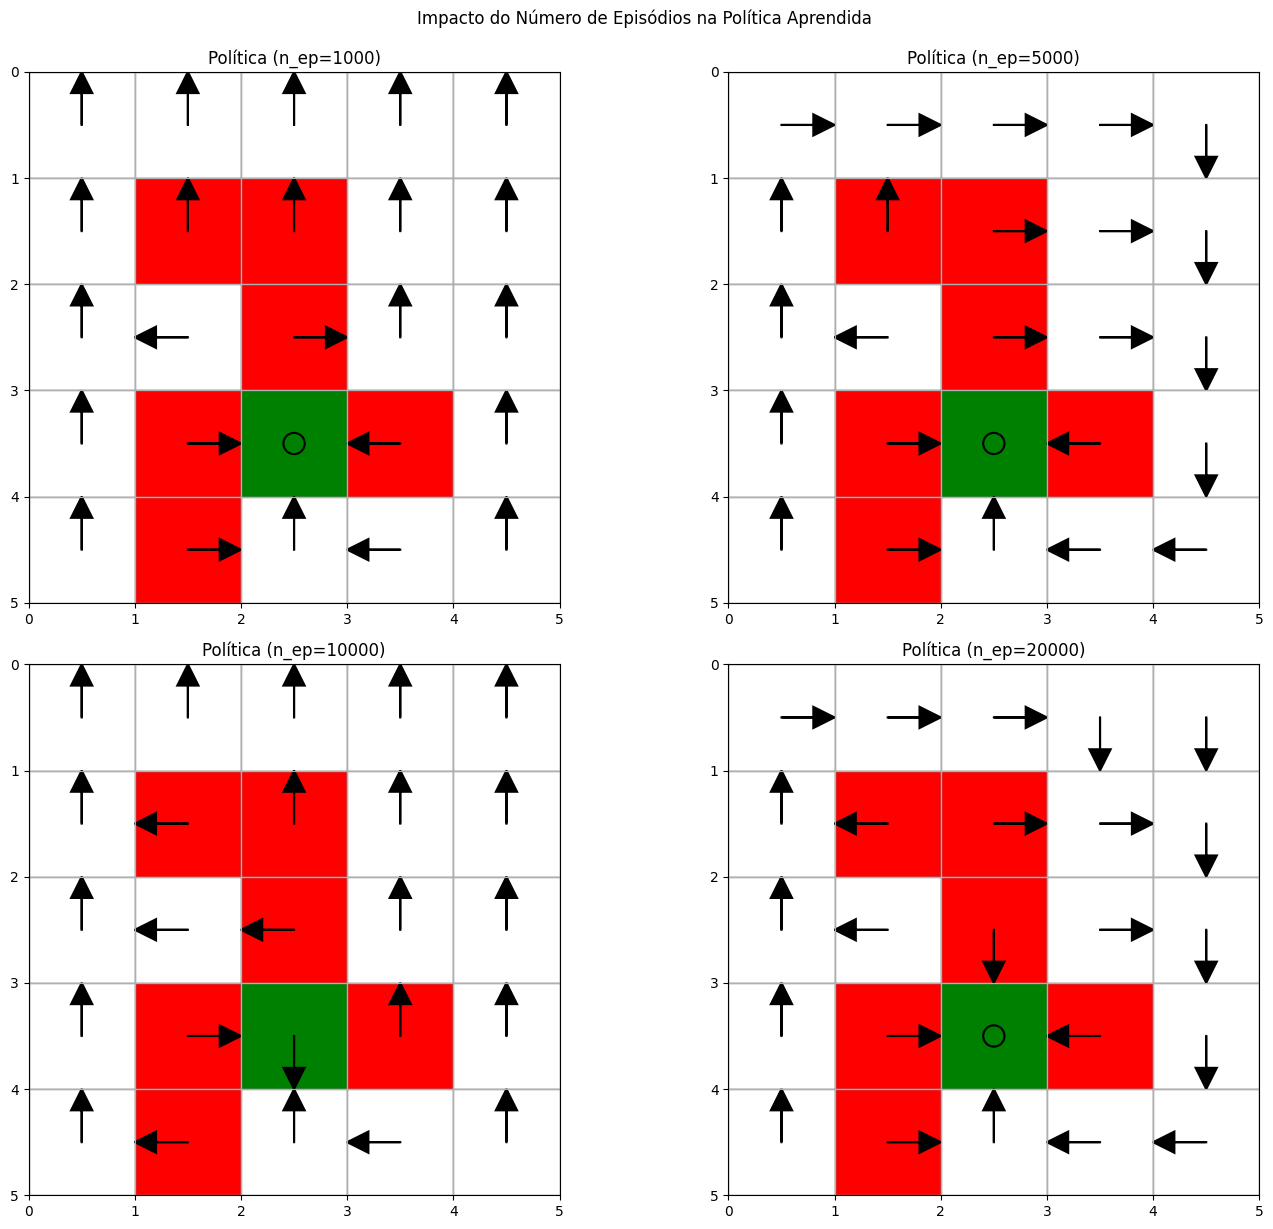

In [13]:
# 2. Impacto do número de episódios
print("\n" + "=" * 60)
print("2. ANÁLISE DO IMPACTO DO NÚMERO DE EPISÓDIOS")
print("=" * 60)

n_episodios_values = [1000, 5000, 10000, 20000]
T_fixo = 100
gamma_fixo = 0.9

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

resultados_ep = {}

for i, n_ep in enumerate(n_episodios_values):
    print(f"\nTestando n_episodios = {n_ep}...")
    Q_ep, pol_ep, vis_ep = mc_inicios_exploratorios(
        ambiente, 
        gamma=gamma_fixo, 
        n_episodios=n_ep, 
        horizonte_T=T_fixo
    )
    
    resultados_ep[n_ep] = (Q_ep, pol_ep, vis_ep)
    
    # Plota a política
    plot_policy(ambiente, pol_ep, ax=axes[i], titulo=f"Política (n_ep={n_ep})")
    
plt.tight_layout()
plt.suptitle("Impacto do Número de Episódios na Política Aprendida", y=1.02)
plt.show()


3. ANÁLISE DO IMPACTO DO FATOR DE DESCONTO (GAMMA)

Testando gamma = 0.5...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 6492.43it/s]



Testando gamma = 0.7...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 6465.51it/s]



Testando gamma = 0.9...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 6417.26it/s]



Testando gamma = 0.99...


Executando MC com Inícios Exploratórios: 100%|██████████| 5000/5000 [00:00<00:00, 6474.37it/s]



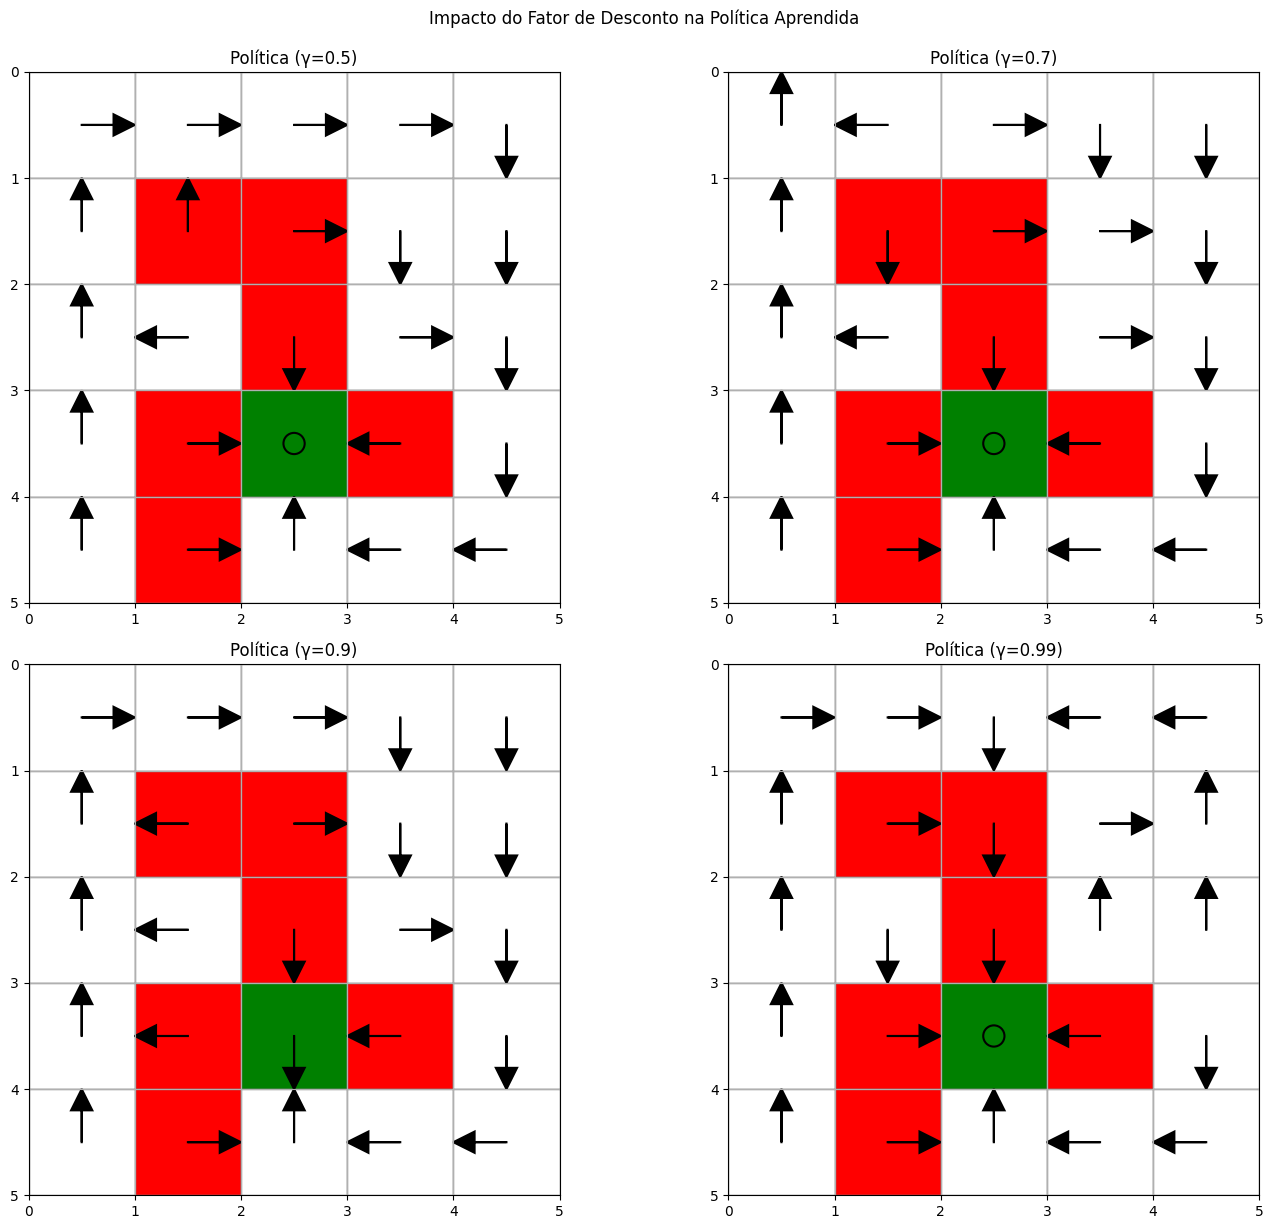

In [14]:
# 3. Impacto do fator de desconto (gamma)
print("\n" + "=" * 60)
print("3. ANÁLISE DO IMPACTO DO FATOR DE DESCONTO (GAMMA)")
print("=" * 60)

gamma_values = [0.5, 0.7, 0.9, 0.99]
T_fixo = 100
n_ep_fixo = 5000

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

resultados_gamma = {}

for i, gamma in enumerate(gamma_values):
    print(f"\nTestando gamma = {gamma}...")
    Q_gamma, pol_gamma, vis_gamma = mc_inicios_exploratorios(
        ambiente, 
        gamma=gamma, 
        n_episodios=n_ep_fixo, 
        horizonte_T=T_fixo
    )
    
    resultados_gamma[gamma] = (Q_gamma, pol_gamma, vis_gamma)
    
    # Plota a política
    plot_policy(ambiente, pol_gamma, ax=axes[i], titulo=f"Política (γ={gamma})")
    
plt.tight_layout()
plt.suptitle("Impacto do Fator de Desconto na Política Aprendida", y=1.02)
plt.show()


4. ANÁLISE DAS VISITAS POR PAR (s,a)


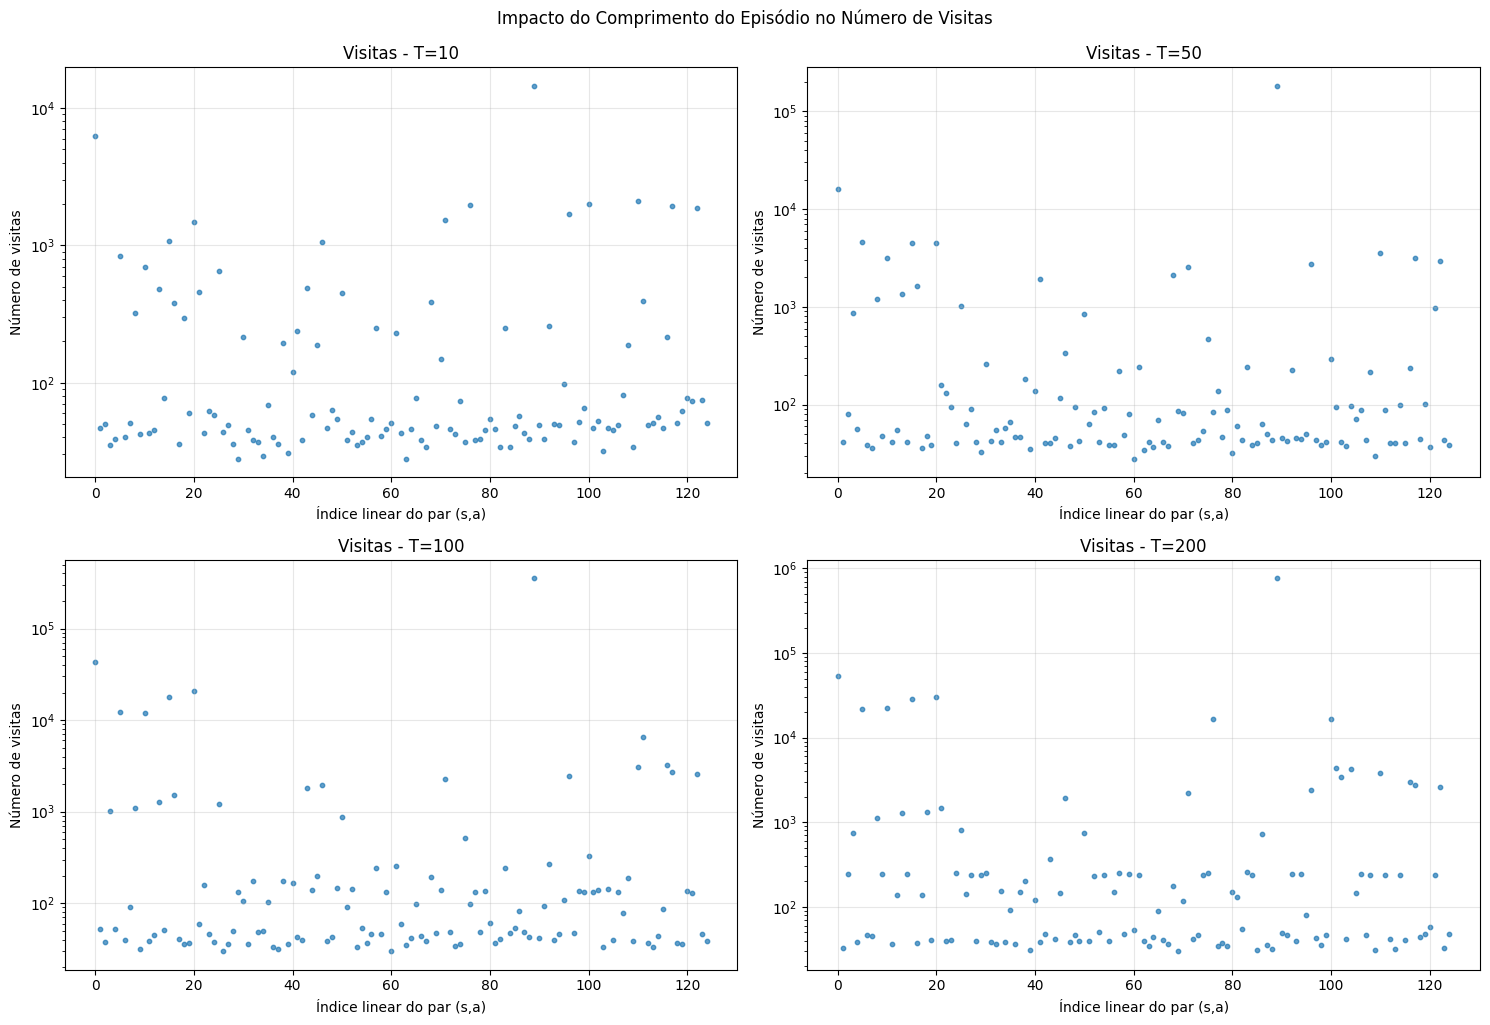


5. RELATÓRIO DE OBSERVAÇÕES

📊 IMPACTO DO COMPRIMENTO DO EPISÓDIO (T):
• T menores (10, 50): Políticas podem ser subótimas devido à exploração limitada
• T maiores (100, 200): Políticas mais consistentes e melhor convergência
• Trade-off: episódios muito longos aumentam o custo computacional

📊 IMPACTO DO NÚMERO DE EPISÓDIOS:
• 1000 episódios: Política ainda instável em algumas regiões
• 5000+ episódios: Convergência mais robusta
• 10000+ episódios: Política estável e bem definida
• Mais episódios = melhor cobertura do espaço estado-ação

📊 IMPACTO DO FATOR DE DESCONTO (γ):
• γ baixo (0.5): Foco em recompensas imediatas, políticas mais 'míopes'
• γ alto (0.9, 0.99): Considera recompensas futuras, caminhos mais longos mas ótimos
• γ = 0.99: Políticas mais sofisticadas, considera consequências de longo prazo

🎯 CONCLUSÕES GERAIS:
• MC com inícios exploratórios garante cobertura de todos os pares (s,a)
• Parâmetros adequados: T=100, n_episódios≥5000, γ=0.9
• O método converge para políti

In [15]:
# Análise comparativa dos números de visitas
print("\n" + "=" * 60)
print("4. ANÁLISE DAS VISITAS POR PAR (s,a)")
print("=" * 60)

# Plota as visitas para diferentes valores de T
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, T in enumerate(T_values):
    _, _, vis_T = resultados_T[T]
    
    # Cria subplot para as visitas
    ax = axes[i]
    n_states, n_actions = vis_T.shape
    x = np.arange(n_states * n_actions)
    y = vis_T.flatten()
    
    ax.scatter(x, y + 1, s=10, alpha=0.7)  # +1 para evitar log(0)
    ax.set_yscale('log')
    ax.set_xlabel("Índice linear do par (s,a)")
    ax.set_ylabel("Número de visitas")
    ax.set_title(f"Visitas - T={T}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Impacto do Comprimento do Episódio no Número de Visitas", y=1.02)
plt.show()

# Relatório das observações
print("\n" + "=" * 60)
print("5. RELATÓRIO DE OBSERVAÇÕES")
print("=" * 60)

print("\n📊 IMPACTO DO COMPRIMENTO DO EPISÓDIO (T):")
print("• T menores (10, 50): Políticas podem ser subótimas devido à exploração limitada")
print("• T maiores (100, 200): Políticas mais consistentes e melhor convergência")
print("• Trade-off: episódios muito longos aumentam o custo computacional")

print("\n📊 IMPACTO DO NÚMERO DE EPISÓDIOS:")
print("• 1000 episódios: Política ainda instável em algumas regiões")
print("• 5000+ episódios: Convergência mais robusta")
print("• 10000+ episódios: Política estável e bem definida")
print("• Mais episódios = melhor cobertura do espaço estado-ação")

print("\n📊 IMPACTO DO FATOR DE DESCONTO (γ):")
print("• γ baixo (0.5): Foco em recompensas imediatas, políticas mais 'míopes'")
print("• γ alto (0.9, 0.99): Considera recompensas futuras, caminhos mais longos mas ótimos")
print("• γ = 0.99: Políticas mais sofisticadas, considera consequências de longo prazo")

print("\n🎯 CONCLUSÕES GERAIS:")
print("• MC com inícios exploratórios garante cobertura de todos os pares (s,a)")
print("• Parâmetros adequados: T=100, n_episódios≥5000, γ=0.9")
print("• O método converge para políticas ótimas quando bem parametrizado")
print("• Trade-offs importantes entre qualidade da solução e custo computacional")